- https://docs.pydantic.dev/latest/
- https://pydantic.dev/logfire
- https://logfire.pydantic.dev/docs/
- https://docs.pydantic.dev/latest/api/base_model/

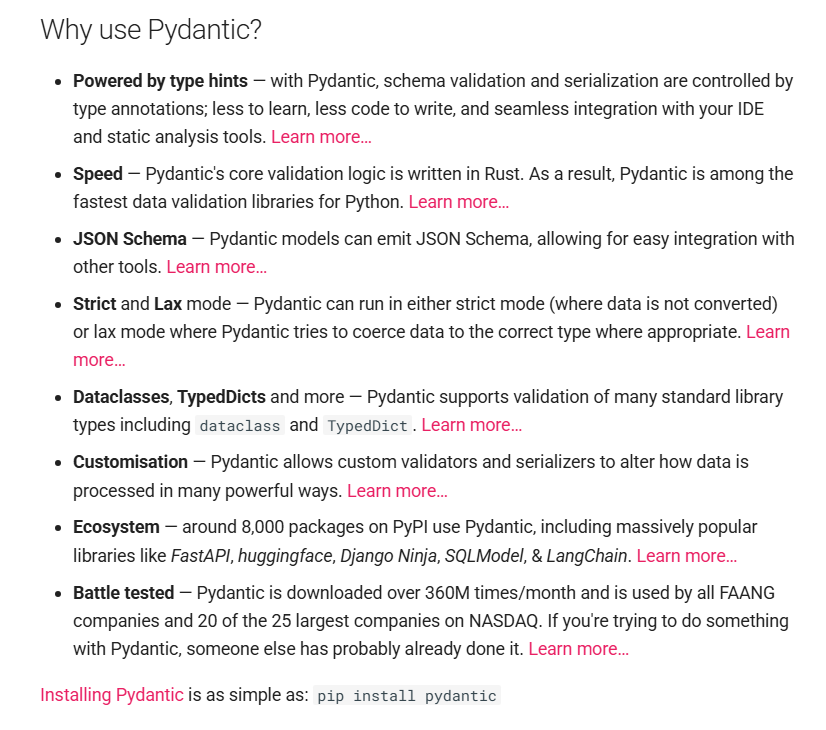

In [1]:
%pip install pydantic
%pip install pydantic[email]
%pip install logfire
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv, find_dotenv
from datetime import datetime
import logfire
import os
from pydantic import BaseModel

In [3]:
_ = load_dotenv(find_dotenv())

In [4]:
_

True

In [5]:
from pydantic import BaseModel, EmailStr
from datetime import date

class User(BaseModel):
    id: int
    name: str
    email: EmailStr
    signup: date

# Input comes in as raw JSON/dict
raw = {"id": "123", "name": "Ada", "email": "ada@example.com", "signup": "2024-07-23"}

user = User(**raw)        
print(user.id)            
print(user.signup)        
print(user.model_dump_json())

123
2024-07-23
{"id":123,"name":"Ada","email":"ada@example.com","signup":"2024-07-23"}


In [6]:
print(type(user.id) )      
print(type(user.name))        
print(type(user.email)) 
print(type(user.signup))       
print(user.model_dump_json())

<class 'int'>
<class 'str'>
<class 'str'>
<class 'datetime.date'>
{"id":123,"name":"Ada","email":"ada@example.com","signup":"2024-07-23"}


**Logfire (a telemetry library) automatically record every successful or failed validation**

In [7]:
LOGFIRE_TOKEN = os.environ.get('LOGFIRE_TOKEN')

logfire.configure(token = LOGFIRE_TOKEN)
logfire.instrument_pydantic()  


class Delivery(BaseModel):
    timestamp: datetime
    dimensions: tuple[int, int]


# this will record details of a successful validation to logfire
m = Delivery(timestamp='2020-01-02T03:04:05Z', dimensions=['10', '20'])
print(repr(m.timestamp))
#> datetime.datetime(2020, 1, 2, 3, 4, 5, tzinfo=TzInfo(UTC))
print(m.dimensions)
#> (10, 20)

# this will cause error
Delivery(timestamp='2020-01-02T03:04:05Z', dimensions=['10'])

18:28:36.847 Pydantic Delivery validate_python


Logfire project URL: ]8;id=319668;https://logfire-us.pydantic.dev/muhammadfarhanaslam/starter-project\https://logfire-us.pydantic.dev/muhammadfarhanaslam/starter-project]8;;\

datetime.datetime(2020, 1, 2, 3, 4, 5, tzinfo=TzInfo(UTC))
(10, 20)
18:28:38.449 Pydantic Delivery validate_python


ValidationError: 1 validation error for Delivery
dimensions.1
  Field required [type=missing, input_value=['10'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

In [8]:
from datetime import datetime

from pydantic import BaseModel, PositiveInt


class User(BaseModel):
    id: int  
    name: str = 'John Doe'  
    signup_ts: datetime | None  
    tastes: dict[str, PositiveInt]  


external_data = {
    'id': 123,
    'signup_ts': '2019-06-01 12:22',  
    'tastes': {
        'wine': 9,
        b'cheese': 7,  
        'cabbage': '1',  
    },
}

user = User(**external_data)  

print(user.id)  
#> 123
print(user.model_dump())  
"""
{
    'id': 123,
    'name': 'John Doe',
    'signup_ts': datetime.datetime(2019, 6, 1, 12, 22),
    'tastes': {'wine': 9, 'cheese': 7, 'cabbage': 1},
}
"""

18:28:46.713 Pydantic User validate_python
123
{'id': 123, 'name': 'John Doe', 'signup_ts': datetime.datetime(2019, 6, 1, 12, 22), 'tastes': {'wine': 9, 'cheese': 7, 'cabbage': 1}}


"\n{\n    'id': 123,\n    'name': 'John Doe',\n    'signup_ts': datetime.datetime(2019, 6, 1, 12, 22),\n    'tastes': {'wine': 9, 'cheese': 7, 'cabbage': 1},\n}\n"

In [9]:
# continuing the above example...

from datetime import datetime
from pydantic import BaseModel, PositiveInt, ValidationError


class User(BaseModel):
    id: int
    name: str = 'John Doe'
    signup_ts: datetime | None
    tastes: dict[str, PositiveInt]


external_data = {'id': 'not an int', 'tastes': {}}  

try:
    User(**external_data)  
except ValidationError as e:
    print(e.errors())
    """
    [
        {
            'type': 'int_parsing',
            'loc': ('id',),
            'msg': 'Input should be a valid integer, unable to parse string as an integer',
            'input': 'not an int',
            'url': 'https://errors.pydantic.dev/2/v/int_parsing',
        },
        {
            'type': 'missing',
            'loc': ('signup_ts',),
            'msg': 'Field required',
            'input': {'id': 'not an int', 'tastes': {}},
            'url': 'https://errors.pydantic.dev/2/v/missing',
        },
    ]
    """

18:28:49.729 Pydantic User validate_python
[{'type': 'int_parsing', 'loc': ('id',), 'msg': 'Input should be a valid integer, unable to parse string as an integer', 'input': 'not an int', 'url': 'https://errors.pydantic.dev/2.11/v/int_parsing'}, {'type': 'missing', 'loc': ('signup_ts',), 'msg': 'Field required', 'input': {'id': 'not an int', 'tastes': {}}, 'url': 'https://errors.pydantic.dev/2.11/v/missing'}]


In [15]:
from pydantic import BaseModel, EmailStr, validator, field_validator

# @validator deprecated. Use @field_validator

class User(BaseModel):
    name: str
    email: EmailStr
    account_id: int

    @field_validator('account_id')
    def validate_account_id(cls, value:int):

        if value <= 0:
            raise ValueError(f"Account ID must be Positive: {value}")
        return value
    
user1: User = User(name="Muhammad Farhan Aslam", email="farhan@gamil.org", account_id=200)

user_json_str: str = user1.model_dump_json()
print(user_json_str, type(user_json_str))

user_obj : User = User.model_validate_json(user_json_str)
print(user_obj)

18:31:11.916 Pydantic User validate_python
{"name":"Muhammad Farhan Aslam","email":"farhan@gamil.org","account_id":200} <class 'str'>
18:31:11.919 Pydantic User validate_json
name='Muhammad Farhan Aslam' email='farhan@gamil.org' account_id=200


In [16]:
from pydantic import BaseModel, EmailStr, validator, field_validator

# @validator deprecated. Use @field_validator

class User(BaseModel):
    name: str
    email: EmailStr
    account_id: int

    @field_validator('account_id')
    def validate_account_id(cls, value:int):  # custom validator function

        if value <= 0:
            raise ValueError(f"Account ID must be Positive: {value}")
        return value
    
user1: User = User(name="Muhammad Farhan Aslam", email="farhan@gamil.org", account_id=-200)

user_json_str: str = user1.model_dump_json()
print(user_json_str, type(user_json_str))

user_obj : User = User.model_validate_json(user_json_str)
print(user_obj)

18:31:32.954 Pydantic User validate_python


ValidationError: 1 validation error for User
account_id
  Value error, Account ID must be Positive: -200 [type=value_error, input_value=-200, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error

In [11]:
from typing import Any

from pydantic import BaseModel, model_validator


class UserModel(BaseModel):
    username: str

    @model_validator(mode='before')
    @classmethod
    def check_card_number_not_present(cls, data: Any) -> Any:  
        if isinstance(data, dict):  
            if 'card_number' in data:
                raise ValueError("'card_number' should not be included")
        return data

In [12]:
import logging
from typing import Any

from typing_extensions import Self

from pydantic import BaseModel, ModelWrapValidatorHandler, ValidationError, model_validator


class UserModel(BaseModel):
    username: str

    @model_validator(mode='wrap')
    @classmethod
    def log_failed_validation(cls, data: Any, handler: ModelWrapValidatorHandler[Self]) -> Self:
        try:
            return handler(data)
        except ValidationError:
            logging.error('Model %s failed to validate with data %s', cls, data)
            raise

In [17]:
from pydantic import BaseModel, field_validator
import re

class User(BaseModel):
    name: str

    @field_validator('name')
    def name_must_be_alpha(cls, v):
        if not re.match(r'^[a-zA-Z\s]+$', v):
            raise ValueError('Name must contain only letters and spaces')
        if len(v.strip()) == 0:
            raise ValueError('Name cannot be empty or just spaces')
        return v.title()  

user = User(name="muhammad farhan")
print(user.name) 

18:32:15.144 Pydantic User validate_python
Muhammad Farhan


In [18]:
from pydantic import BaseModel, field_validator
import re

class User(BaseModel):
    name: str

    @field_validator('name')
    def name_must_be_alpha(cls, v):
        if not re.match(r'^[a-zA-Z\s]+$', v):
            raise ValueError('Name must contain only letters and spaces')
        if len(v.strip()) == 0:
            raise ValueError('Name cannot be empty or just spaces')
        return v.title()  

user = User(name="")
print(user.name)  

18:32:32.990 Pydantic User validate_python


ValidationError: 1 validation error for User
name
  Value error, Name must contain only letters and spaces [type=value_error, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error